In [23]:
using Plots, DifferentialEquations,LaTeXStrings

In [30]:
#def constants
γ = 0.1
Ω = 0
γ_sen = 0.1
Δ=0

0

In [31]:
#def the problem state vector :(ρ₂₂,ρ₁₁,ρ₂₁, ρ₁₂)
"""
du = change in state 
u = current state
p = parameters
t = time
"""
function bloch!(du, u, p, t) 
    du[1] = -γ*u[1]-(im/2 *Ω*u[3]-im/2*conj(Ω)*u[4]  )
    du[2] = +γ*u[1]+(im/2 *Ω*u[3]-im/2*conj(Ω)*u[4]  )
    du[3] = -(im*Δ+γ_sen)*u[3]-im/2*Ω*(u[1]-u[2])
    du[4] = -(-im*Δ+γ_sen)*u[4]+im/2*Ω*(u[1]-u[2])
end


bloch!

In [32]:
# desing problem 
u0 = ComplexF64[1.0; 0; 0.0;0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(bloch!, u0, tspan)
sol = solve(prob) 

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 14-element Vector{Float64}:
   0.0
   0.00999000500498377
   0.10989005505482147
   1.1088905555531983
   4.563004540305134
  10.375580786394565
  17.827804493080816
  26.510618774963312
  36.624786724011635
  48.34869982262343
  66.43086174117931
  77.10008575485216
  95.4722397365088
 100.0
u: 14-element Vector{Vector{ComplexF64}}:
 [1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.9990014983343757 + 0.0im, 0.0009985016656243035 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.98907115305296 + 0.0im, 0.010928846947039998 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.8950380429195136 + 0.0im, 0.10496195708048639 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.6336234338315547 + 0.0im, 0.3663765661684453 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.3543188466121904 + 0.0im, 0.6456811533878096 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.16816991217225724 + 0.0im, 0.8318300878277428 

In [33]:
#function for plotting
f(t, x ) = (t, real(x))

f (generic function with 1 method)

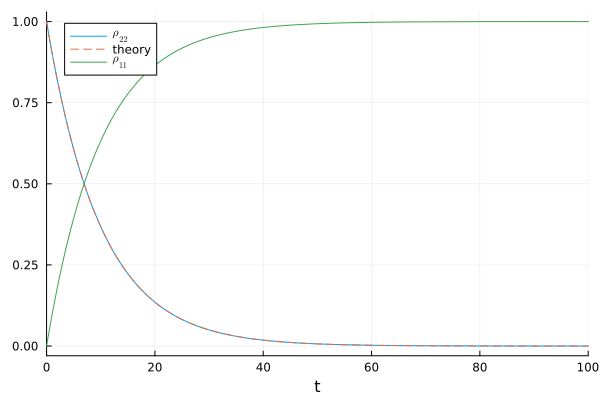

In [38]:
plot(sol,idxs =(f,0,1),label=L"\rho_{22}")
plot!(0:0.1:100,t->1*exp(-γ*t),ls=:dash,label="theory")
plot!(sol,idxs =(f,0,2),label=L"\rho_{11}")